In [1]:
import pandas as pd
import ast

import geopandas as gpd
import osmnx as ox
import contextily as cx
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt 

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
gdf_raw = gpd.read_file('../../data/raw/noise_cph_frb.json')
gdf_raw = gdf_raw.to_crs(epsg=25832)

In [3]:
gdf_raw = gdf_raw[["id", "weighted_noise", 'betweenness']]

In [4]:
#Getting meta data for each of the raods. Used to more accurate model the noise. 
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')
# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)
edges = edges.reset_index() #Collabse hierachy structure
edges.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,bridge,ref,service,width,access,tunnel,junction
0,118725,298795432,0,27226011,True,Banegårdspladsen,tertiary,30,112.872,"LINESTRING (724025.025 6175551.339, 724031.889...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118725,6357644306,0,140412993,True,Vesterbrogade,tertiary,50,40.497,"LINESTRING (724025.025 6175551.339, 724051.956...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,298795432,298795496,0,244360867,True,Banegårdspladsen,tertiary,30,89.801,"LINESTRING (724075.369 6175450.104, 724076.732...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6357644306,2378383724,0,678991574,True,Vesterbrogade,tertiary,50,21.930,"LINESTRING (724059.919 6175572.112, 724075.704...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6357644306,6357644350,0,679140293,True,Vesterbrogade,tertiary,50,23.056,"LINESTRING (724059.919 6175572.112, 724081.508...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# In gdf, the "id" is a tuple of u,v,key. In order to join gdf with the edges dataframe created above,
# we have to extract u,v,key from the tuble and cast it to new columns
gdf_raw['id_tuple'] = gdf_raw['id'].apply(ast.literal_eval)
gdf_raw['u'] = gdf_raw['id_tuple'].apply(lambda x: x[0])
gdf_raw['v'] = gdf_raw['id_tuple'].apply(lambda x: x[1])
gdf_raw['key'] = gdf_raw['id_tuple'].apply(lambda x: x[2])

# Dropping the temporary 'id_tuple' column 
gdf_raw.drop(columns=['id_tuple'], inplace=True)

In [6]:
gdf_raw = gdf_raw.merge(edges, how = "right", on=["u","v","key"])

In [7]:
gdf_raw.fillna(0, inplace=True)

In [8]:
columns = ['highway', 'bridge', 'maxspeed', 'width', 'lanes']
for column in columns:
    gdf_raw[column] = gdf_raw[column].apply(lambda x: x[0] if isinstance(x, list) else x)

In [10]:
top_4_highways = gdf_raw['highway'].value_counts().nlargest(4).index
gdf_raw['highway'] = gdf_raw['highway'].apply(lambda x: x if x in top_4_highways else 'other')
gdf_processed = pd.get_dummies(gdf_raw, columns=['highway'])


In [29]:
gdf_processed[features]

,length,betweenness,maxspeed,length,lanes,width,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
0,112.872,3.989112e-07,30,112.872,0,0.0,0,0,0,0,1
1,40.497,4.920812e-05,50,40.497,2,0.0,0,0,0,0,1
2,89.801,3.445143e-07,30,89.801,0,0.0,0,0,0,0,1
3,21.930,8.464776e-06,50,21.930,2,0.0,0,0,0,0,1
4,23.056,4.059224e-05,50,23.056,1,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
62434,12.110,0.000000e+00,0,12.110,0,0.0,1,0,0,0,0
62435,19.362,0.000000e+00,0,19.362,0,7.0,1,0,0,0,0
62436,88.594,0.000000e+00,0,88.594,0,0.0,1,0,0,0,0
62437,21.964,0.000000e+00,0,21.964,0,0.0,0,0,0,1,0


In [12]:
features = [
    'length', 
    'betweenness', 
    'maxspeed', 
    'length', 
    'lanes',  
    'width',
    'highway_other',
    'highway_path',
    'highway_residential',
    'highway_service',
    'highway_tertiary'
]
target = 'weighted_noise'

In [13]:
gdf_processed['width'] = pd.to_numeric(gdf_processed['width'], errors='coerce')
gdf_processed['lanes'] = pd.to_numeric(gdf_processed['lanes'], errors='coerce')
gdf_processed['maxspeed'] = pd.to_numeric(gdf_processed['maxspeed'], errors='coerce')

In [14]:
# Separate rows with and without the target feature
train_data = gdf_processed[gdf_processed[target] > 0.0]
test_data = gdf_processed[gdf_processed[target] == 0.0]

X_train = train_data[features]
y_train = train_data[target]


X_test = test_data[features]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
X_train.dtypes #Ensure we do not have any 'object' datatypes, as the RandomForestRegressor wont accept that

length                 float64
betweenness            float64
maxspeed                 int64
length                 float64
lanes                    int64
width                  float64
highway_other            uint8
highway_path             uint8
highway_residential      uint8
highway_service          uint8
highway_tertiary         uint8
dtype: object

In [16]:
model = RandomForestRegressor(n_estimators=100,  random_state=42, )
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = model.score(X_val, y_val)


print(f"RMSE: {rmse}, MAE: {mae}, r2: {r2}")

RMSE: 3.9239906977674615, MAE: 2.8068420810911583, r2: 0.5451957851831852


In [18]:
# Predict the missing values
predictions = model.predict(X_test)

# Assign the predicted values back to the test_data
test_data[target] = predictions

In [47]:
test_data.rename(columns={'weighted_noise': 'predicted_noise'}, inplace=True)
gdf_ny = gpd.GeoDataFrame(test_data, geometry=test_data.geometry)
gdf_ny.set_crs(epsg=25832, inplace=True)

,id,predicted_noise,betweenness,u,v,key,osmid,oneway,name,maxspeed,...,service,width,access,tunnel,junction,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
20,"(118744, 1277939659, 0)",57.476106,0.000002,118744,1277939659,0,699713644,True,0,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0
22,"(118744, 1277939654, 0)",59.610823,0.000003,118744,1277939654,0,112439593,False,0,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0
23,"(1277939659, 6167979440, 0)",54.496424,0.000002,1277939659,6167979440,0,699713644,True,0,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0
25,"(1277939659, 6167979447, 0)",58.044280,0.000000,1277939659,6167979447,0,112439593,False,0,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0
26,"(1277939654, 6167979447, 0)",58.095361,0.000002,1277939654,6167979447,0,112439596,False,0,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62434,0,68.236255,0.000000,11829253277,11829253278,0,1273936398,False,0,0,...,0,0.0,0,0,0,1,0,0,0,0
62435,0,55.005869,0.000000,11886461653,11834934599,0,1274613261,False,0,0,...,0,7.0,0,0,0,1,0,0,0,0
62436,0,56.628404,0.000000,11886461653,11834934657,0,1280544121,True,0,0,...,0,0.0,0,0,0,1,0,0,0,0
62437,0,55.312830,0.000000,11837321069,11837321086,0,"[1274879064, 327313131]",False,Grønvangen,0,...,parking_aisle,0.0,0,0,0,0,0,0,1,0


In [52]:
gdf_pred = gdf_ny[['u','v','key','predicted_noise','geometry']]

In [54]:
gdf_pred.to_file('../../data/raw/noise_frb_pred.json')

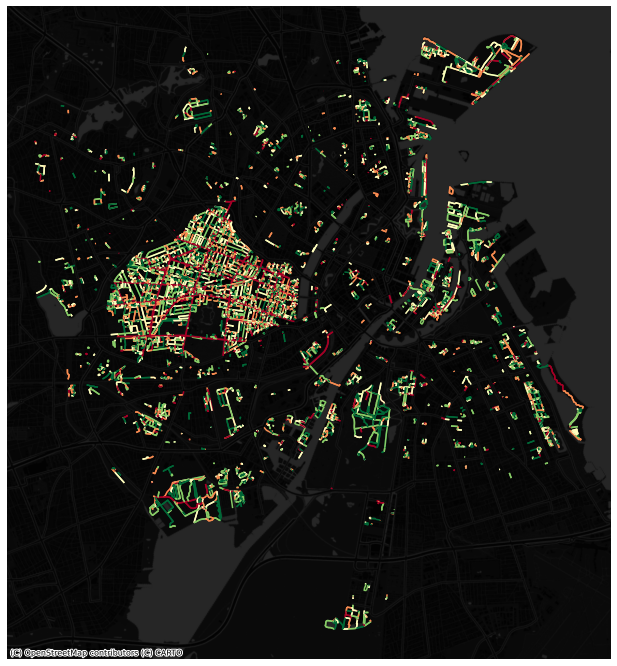

In [56]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_pred.plot(
    column='predicted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_pred.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../../pictures/street_noise_map_frb_pred.png')


In [95]:
gdf_cph = gdf_processed[gdf_processed.weighted_noise > 0.0]

In [101]:
gdf_cph = gpd.GeoDataFrame(gdf_cph, geometry='geometry')

# Set the CRS to EPSG:25832
gdf_cph.set_crs(epsg=25832, inplace=True)

,id,weighted_noise,betweenness,u,v,key,osmid,oneway,name,maxspeed,...,service,width,access,tunnel,junction,highway_other,highway_path,highway_residential,highway_service,highway_tertiary
0,"(118725, 298795432, 0)",64.385753,3.989112e-07,118725,298795432,0,27226011,True,Banegårdspladsen,30,...,0,0.0,0,0,0,0,0,0,0,1
1,"(118725, 6357644306, 0)",68.661369,4.920812e-05,118725,6357644306,0,140412993,True,Vesterbrogade,50,...,0,0.0,0,0,0,0,0,0,0,1
2,"(298795432, 298795496, 0)",62.504355,3.445143e-07,298795432,298795496,0,244360867,True,Banegårdspladsen,30,...,0,0.0,0,0,0,0,0,0,0,1
3,"(6357644306, 2378383724, 0)",68.322808,8.464776e-06,6357644306,2378383724,0,678991574,True,Vesterbrogade,50,...,0,0.0,0,0,0,0,0,0,0,1
4,"(6357644306, 6357644350, 0)",68.269927,4.059224e-05,6357644306,6357644350,0,679140293,True,Vesterbrogade,50,...,0,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62244,"(11711274854, 11711274853, 0)",61.065619,0.000000e+00,11711274854,11711274853,0,1259698977,False,0,0,...,0,0.0,0,0,0,0,0,0,1,0
62245,"(11711295424, 11711295425, 0)",53.000000,0.000000e+00,11711295424,11711295425,0,1259704055,False,0,0,...,0,0.0,0,0,0,0,1,0,0,0
62249,"(11753352366, 4199771189, 0)",69.000000,0.000000e+00,11753352366,4199771189,0,419993041,True,0,0,...,0,0.0,0,0,0,1,0,0,0,0
62250,"(11753352367, 299506947, 0)",69.000000,0.000000e+00,11753352367,299506947,0,"[689364546, 26819900]",True,Bispeengbuen,50,...,0,0.0,0,0,0,0,0,0,0,1


In [145]:
abc = gdf_cph.merge(gdf_pred, on=['u','v','key'],how='outer')


In [146]:
list(abc)

['id',
 'weighted_noise',
 'betweenness',
 'u',
 'v',
 'key',
 'osmid',
 'oneway',
 'name',
 'maxspeed',
 'length',
 'geometry_x',
 'lanes',
 'bridge',
 'ref',
 'service',
 'width',
 'access',
 'tunnel',
 'junction',
 'highway_other',
 'highway_path',
 'highway_residential',
 'highway_service',
 'highway_tertiary',
 'predicted_noise',
 'geometry_y']

In [147]:
abc['combined_noise'] = abc['predicted_noise'].combine_first(abc['weighted_noise'])
abc['geometry'] = abc['geometry_x'].combine_first(abc['geometry_y'])


In [137]:
abc = abc[['u','v','key','weighted_noise', 'predicted_noise', 'combined_noise']]

In [139]:
abc.to_csv('../../data/noise_edges.csv',index=False)

In [148]:
abc = gpd.GeoDataFrame(abc, geometry='geometry')

# Set the CRS to EPSG:25832
abc.set_crs(epsg=25832, inplace=True)

,id,weighted_noise,betweenness,u,v,key,osmid,oneway,name,maxspeed,...,junction,highway_other,highway_path,highway_residential,highway_service,highway_tertiary,predicted_noise,geometry_y,combined_noise,geometry
0,"(118725, 298795432, 0)",64.385753,3.989112e-07,118725,298795432,0,27226011,True,Banegårdspladsen,30.0,...,0,0.0,0.0,0.0,0.0,1.0,NaN,None,64.385753,"LINESTRING (724025.025 6175551.339, 724031.889..."
1,"(118725, 6357644306, 0)",68.661369,4.920812e-05,118725,6357644306,0,140412993,True,Vesterbrogade,50.0,...,0,0.0,0.0,0.0,0.0,1.0,NaN,None,68.661369,"LINESTRING (724025.025 6175551.339, 724051.956..."
2,"(298795432, 298795496, 0)",62.504355,3.445143e-07,298795432,298795496,0,244360867,True,Banegårdspladsen,30.0,...,0,0.0,0.0,0.0,0.0,1.0,NaN,None,62.504355,"LINESTRING (724075.369 6175450.104, 724076.732..."
3,"(6357644306, 2378383724, 0)",68.322808,8.464776e-06,6357644306,2378383724,0,678991574,True,Vesterbrogade,50.0,...,0,0.0,0.0,0.0,0.0,1.0,NaN,None,68.322808,"LINESTRING (724059.919 6175572.112, 724075.704..."
4,"(6357644306, 6357644350, 0)",68.269927,4.059224e-05,6357644306,6357644350,0,679140293,True,Vesterbrogade,50.0,...,0,0.0,0.0,0.0,0.0,1.0,NaN,None,68.269927,"LINESTRING (724059.919 6175572.112, 724081.508..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62434,NaN,NaN,NaN,11829253277,11829253278,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.236255,"LINESTRING (724148.784 6175265.946, 724160.933...",68.236255,"LINESTRING (724148.784 6175265.946, 724160.933..."
62435,NaN,NaN,NaN,11886461653,11834934599,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.005869,"LINESTRING (723790.304 6174588.639, 723792.301...",55.005869,"LINESTRING (723790.304 6174588.639, 723792.301..."
62436,NaN,NaN,NaN,11886461653,11834934657,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56.628404,"LINESTRING (723790.304 6174588.639, 723782.760...",56.628404,"LINESTRING (723790.304 6174588.639, 723782.760..."
62437,NaN,NaN,NaN,11837321069,11837321086,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,55.312830,"LINESTRING (719712.098 6176675.435, 719709.131...",55.312830,"LINESTRING (719712.098 6176675.435, 719709.131..."


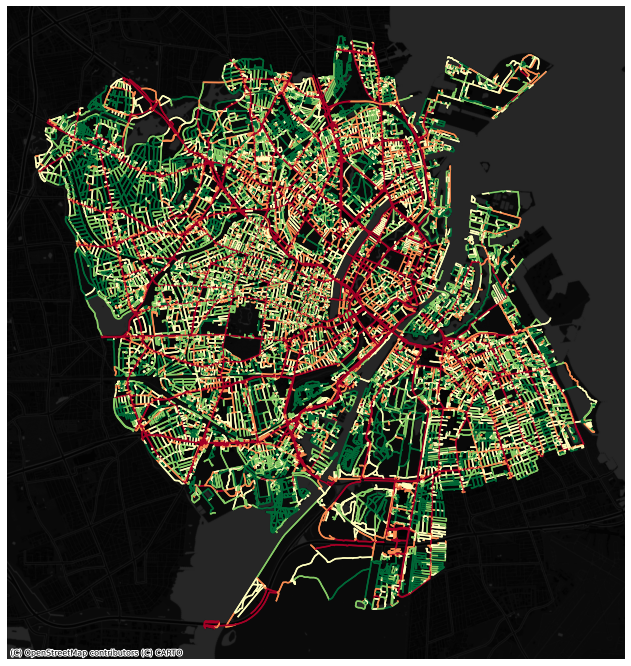

In [149]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
abc.plot(
    column='combined_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=abc.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../../pictures/street_noise_map_final.png')
